<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumCountriesClassifier_07_Naive_Bayes_trigrams_no_upsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [26]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]
    # Limit to first 3 pages because of memory constraints
    if len(pages) > 3:
      pages = pages[:3]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [27]:
def get_num_countries(x):
  if x is not None and type(x) is str:
    return len(x.split(","))
  return None

In [28]:
df_annotations["num_countries"] = df_annotations.country.apply(get_num_countries)

In [29]:
df_annotations["num_countries"].value_counts()

1.0     7998
2.0      726
3.0      341
4.0      263
5.0      230
6.0      225
7.0      193
8.0      176
10.0     155
9.0      137
11.0     135
12.0     116
13.0     109
14.0      92
15.0      90
17.0      78
18.0      68
16.0      65
21.0      57
20.0      56
19.0      54
23.0      47
22.0      44
24.0      35
25.0      31
26.0      27
29.0      22
30.0      21
27.0      20
31.0      19
28.0      18
32.0      17
33.0      14
41.0      11
34.0      11
38.0       8
39.0       8
37.0       7
43.0       7
36.0       6
35.0       6
44.0       6
40.0       6
48.0       6
47.0       3
42.0       2
49.0       2
50.0       2
45.0       1
58.0       1
46.0       1
62.0       1
51.0       1
54.0       1
Name: num_countries, dtype: int64

In [30]:
def get_is_international(num):
    if num is None or pd.isna(num):
      return None
    if num >= 2:
      return 1
    return 0
df_annotations["is_international"] = df_annotations["num_countries"].apply(get_is_international)

In [31]:
df_annotations["is_international"].value_counts()

0.0    7998
1.0    3778
Name: is_international, dtype: int64

# Train and evaluate the number of countries extractor

In [32]:
df_train = df_annotations[(df_annotations.train_val == "train") & (~df_annotations.is_international.isna())]

In [33]:
df_train_to_augment = df_train[df_train.is_international == 1]

In [34]:
df_train_augmented = df_train # pd.concat([df_train, df_train_to_augment])

In [35]:
df_train_augmented["is_international"].value_counts()

0.0    6375
1.0    3052
Name: is_international, dtype: int64

In [36]:
df_val = df_annotations[df_annotations.train_val == "val"]

In [37]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
NUM_FEATURES = 500

# stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
# stops.remove("both")
# stops.remove("all")
stops  = set()

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[a-z][a-z]+', ngram_range=[1,3])
transformer = TfidfTransformer()

nb = BernoulliNB()
model = make_pipeline(vectoriser, transformer, nb)

In [40]:
model.fit(df_train_augmented.text, df_train_augmented.is_international)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500, min_df=5, ngram_range=[1, 3],
                                 stop_words=set(),
                                 token_pattern='[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('bernoullinb', BernoulliNB())])

In [41]:
df_val["pred_international"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
pred_international = df_val["pred_international"]

In [43]:
is_international_ground_truths = df_val.is_international

In [44]:
acc = accuracy_score(is_international_ground_truths.apply(str), pred_international.apply(str))
print (f"Num countries accuracy {acc}")

Num countries accuracy 0.727188940092166


''

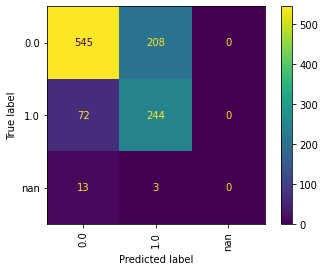

In [45]:
ConfusionMatrixDisplay.from_predictions(is_international_ground_truths.apply(str), pred_international.apply(str))
plt.xticks(rotation=90)
;

In [46]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(2):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")
        if ctr > 25:
          break

Strongest predictors for class 0

0	we
1	principal investigator
2	department of
3	department
4	principal
5	university
6	pi
7	edu
8	effects
9	et al
10	surgery
11	professor
12	cancer center
13	effects of
14	nih
15	intervention
16	university of
17	pain
18	irb
19	of medicine
20	md
21	determine
22	mailto
23	phd
24	increased
25	there
26	medicine
Strongest predictors for class 1

0	eudract
1	eudract number
2	confidential
3	amendment
4	global
5	protocol amendment
6	amended
7	multicenter
8	efficacy and safety
9	ppd ppd
10	document
11	ppd ppd ppd
12	ppd
13	phase
14	property
15	in subjects with
16	property of
17	efficacy and
18	information
19	and safety of
20	randomized double blind
21	confidential page
22	company
23	in subjects
24	this document
25	double blind
26	you
